# Проект по кредитному скорингу: Анализ и построение моделей для предсказания дефолта заемщиков

## Введение

**Цель проекта:** Разработать модель машинного обучения для предсказания вероятности дефолта заемщиков на основе предоставленных данных. Это задача бинарной классификации, где целевой переменной является `SeriousDlqin2yrs` (наличие просрочки более 90 дней).

**Данные:** В проекте используются данные "Give Me Some Credit" от Kaggle. Набор данных содержит информацию о кредитной истории заемщиков, включая различные финансовые показатели и демографические данные.

**Метрика оценки:** Для оценки качества моделей будем использовать `ROC AUC` (площадь под ROC-кривой) как основную метрику, поскольку она хорошо подходит для задач с несбалансированными классами и показывает способность модели различать классы. Также будем рассматривать `accuracy`, `precision`, `recall` и `f1-score` для более полного понимания работы моделей.

**План проекта:**

1.  **Загрузка данных и первичный анализ.**
2.  **Исследовательский анализ данных (EDA):** Визуализация данных, поиск закономерностей и аномалий.
3.  **Предобработка данных:** Обработка пропусков, выбросов, масштабирование признаков.
4.  **Инженерия признаков:** Создание новых признаков на основе имеющихся для улучшения качества моделей.
5.  **Разделение данных на обучающую и тестовую выборки.** (В данном случае у нас уже есть train и test датасеты)
6.  **Обучение различных моделей машинного обучения:** Логистическая регрессия, Random Forest, XGBoost, CatBoost, LightGBM.
7.  **Настройка гиперпараметров моделей и кросс-валидация.**
8.  **Оценка качества моделей на тестовой выборке.**
9.  **Выбор лучшей модели и формирование submission файла.**
10. **Заключение и выводы.**

---

## 1. Загрузка данныхх и первичный анализ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

c:\ProgramData\anaconda3\envs\ml_base\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загрузка данных
data_train = pd.read_csv('data/GiveMeSomeCredit-training.csv')
data_test = pd.read_csv('data/GiveMeSomeCredit-testing.csv')

In [3]:
# Объединим train и test для общей предобработки (кроме целевой переменной и 'Id' в test)
data_combined = pd.concat([data_train, data_test.drop('SeriousDlqin2yrs', axis=1)], axis=0, ignore_index=True)
data_combined['IsTrain'] = np.concatenate([np.ones(len(data_train)), np.zeros(len(data_test))]) # флаг для разделения обратно

In [4]:
# Первые строки данных
print("Первые 5 строк обучающих данных:")
display(data_train.head())

Первые 5 строк обучающих данных:


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
# Статистики по данным
print("\nОписательные статистики обучающих данных:")
display(data_train.describe())


Описательные статистики обучающих данных:


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [6]:
# Информация о типах данных и пропусках
print("\nИнформация о типах данных и пропусках в обучающих данных:")
display(data_train.info())


Информация о типах данных и пропусках в обучающих данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfT

None

In [7]:
# Распределение целевой переменной
print("\nРаспределение целевой переменной 'SeriousDlqin2yrs':")
print(data_train['SeriousDlqin2yrs'].value_counts(normalize=True))


Распределение целевой переменной 'SeriousDlqin2yrs':
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


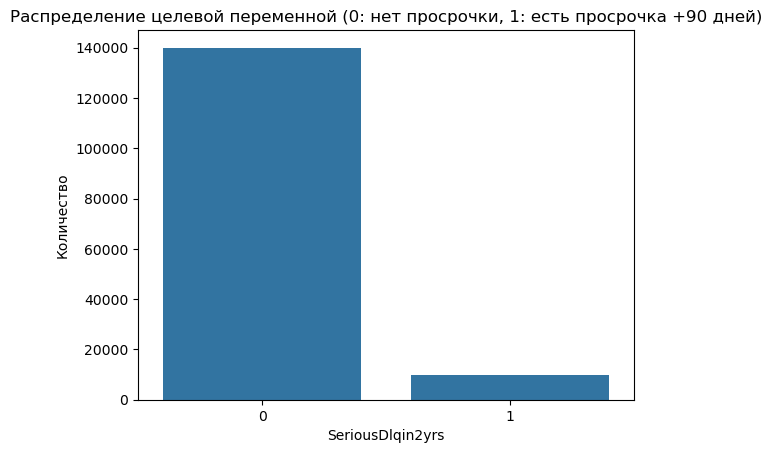

In [8]:
# Визуализация распределения целевой переменной
sns.countplot(x='SeriousDlqin2yrs', data=data_train)
plt.title('Распределение целевой переменной (0: нет просрочки, 1: есть просрочка +90 дней)')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Количество')
plt.show()

---
### Описание признаков

| Variable Name                             | Description                                                                                                                                                           | Type       |
| :---------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :--------- |
| SeriousDlqin2yrs                          | Person experienced 90 days past due delinquency or worse                                                                                                                 | Y/N        |
| RevolvingUtilizationOfUnsecuredLines      | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits             | percentage |
| age                                       | Age of borrower in years                                                                                                                                                | integer    |
| NumberOfTime30-59DaysPastDueNotWorse       | Number of times borrower has been 30-59 days past due but no worse in the last 2 years.                                                                               | integer    |
| DebtRatio                                 | Monthly debt payments, alimony,living costs divided by monthy gross income                                                                                              | percentage |
| MonthlyIncome                             | Monthly income                                                                                                                                                          | real       |
| NumberOfOpenCreditLinesAndLoans           | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)                                                                   | integer    |
| NumberOfTimes90DaysLate                   | Number of times borrower has been 90 days or more past due.                                                                                                              | integer    |
| NumberRealEstateLoansOrLines              | Number of mortgage and real estate loans including home equity lines of credit                                                                                         | integer    |
| NumberOfTime60-89DaysPastDueNotWorse       | Number of times borrower has been 60-89 days past due but no worse in the last 2 years.                                                                               | integer    |
| NumberOfDependents                        | Number of dependents in family excluding themselves (spouse, children etc.)                                                                                             | integer    |
---

## 3. EDA

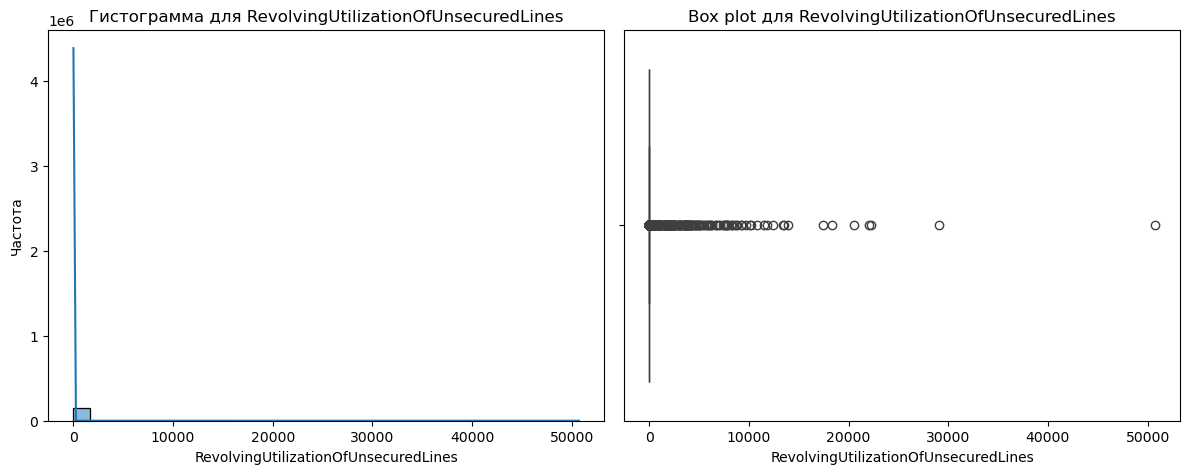

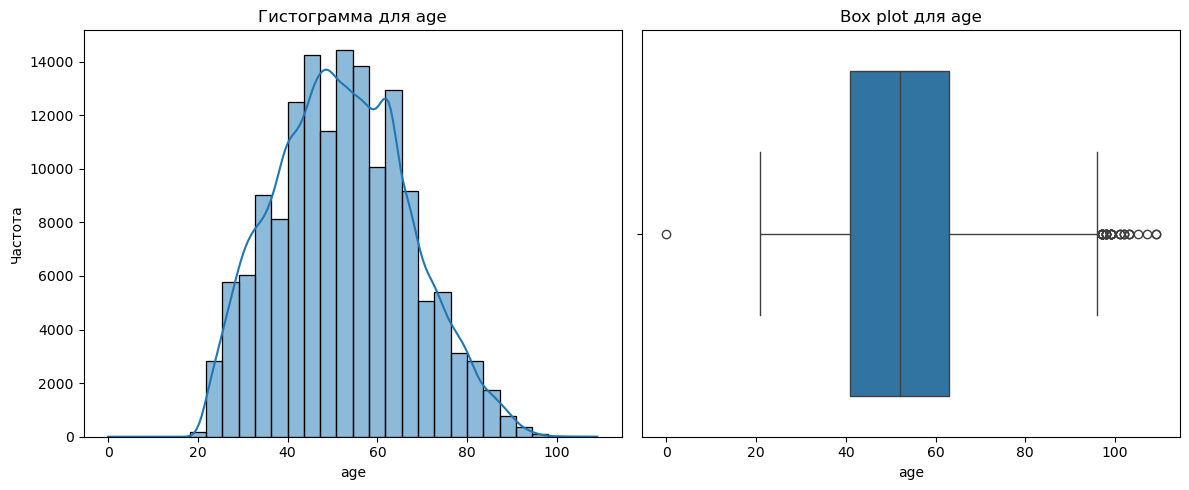

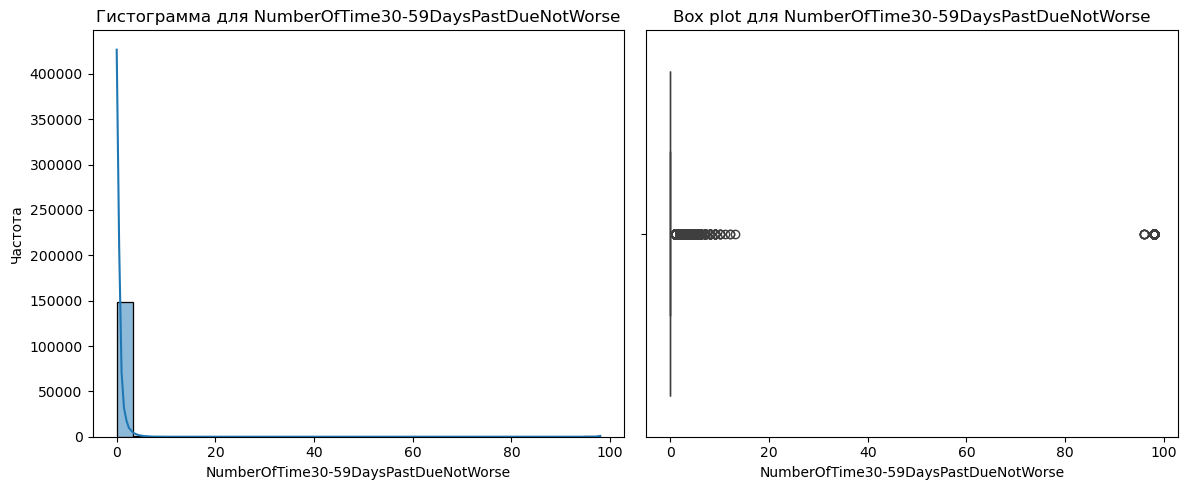

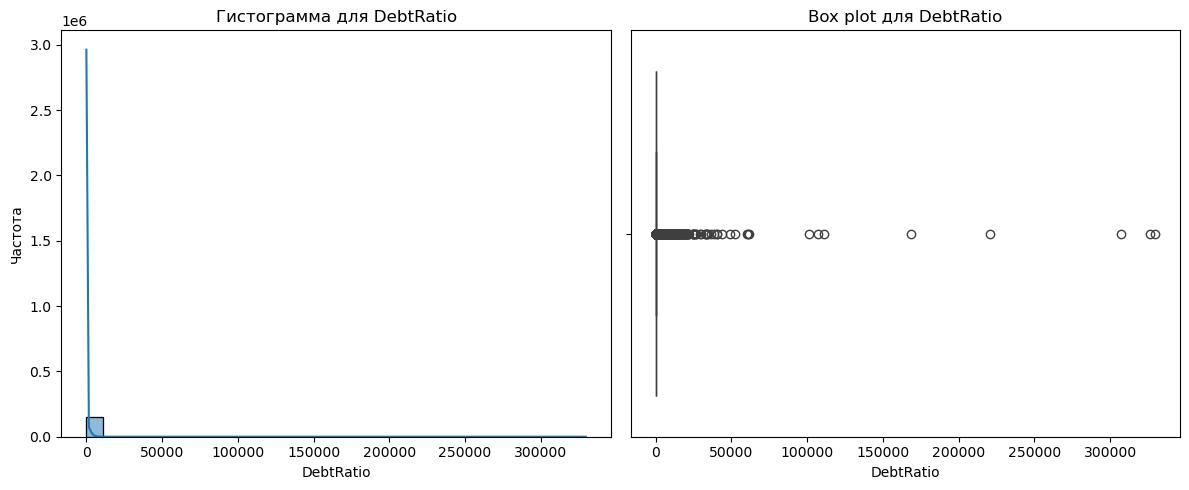

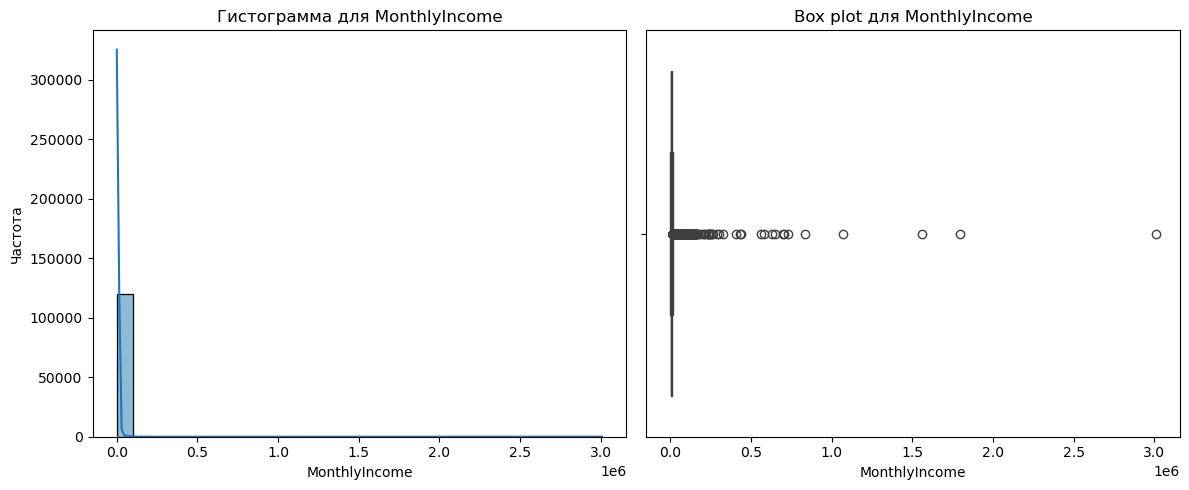

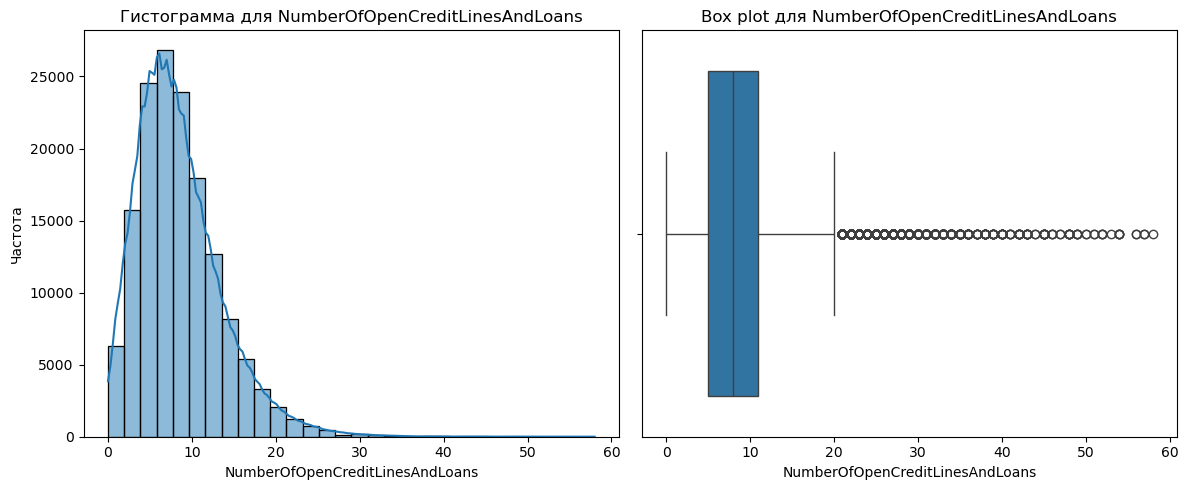

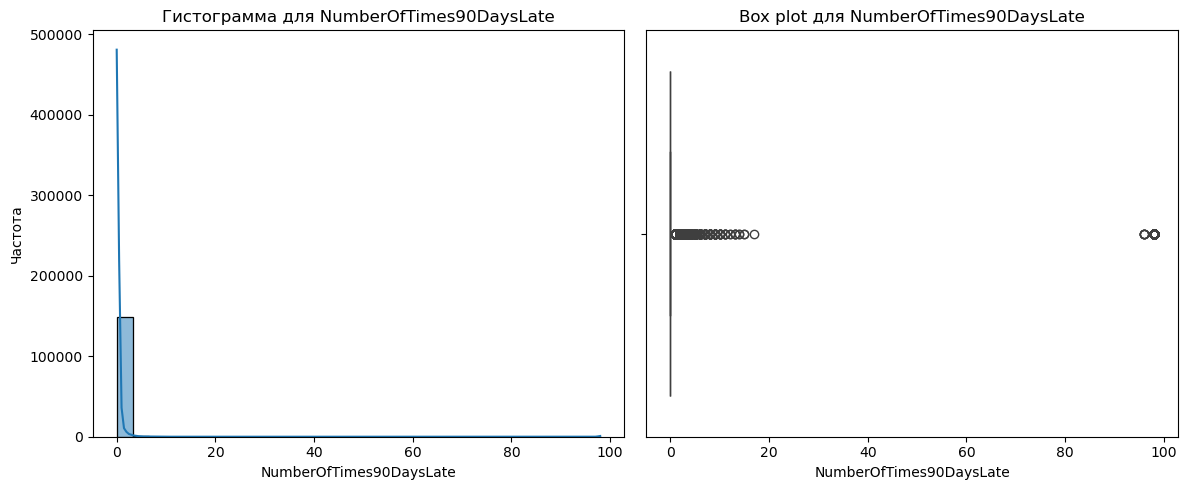

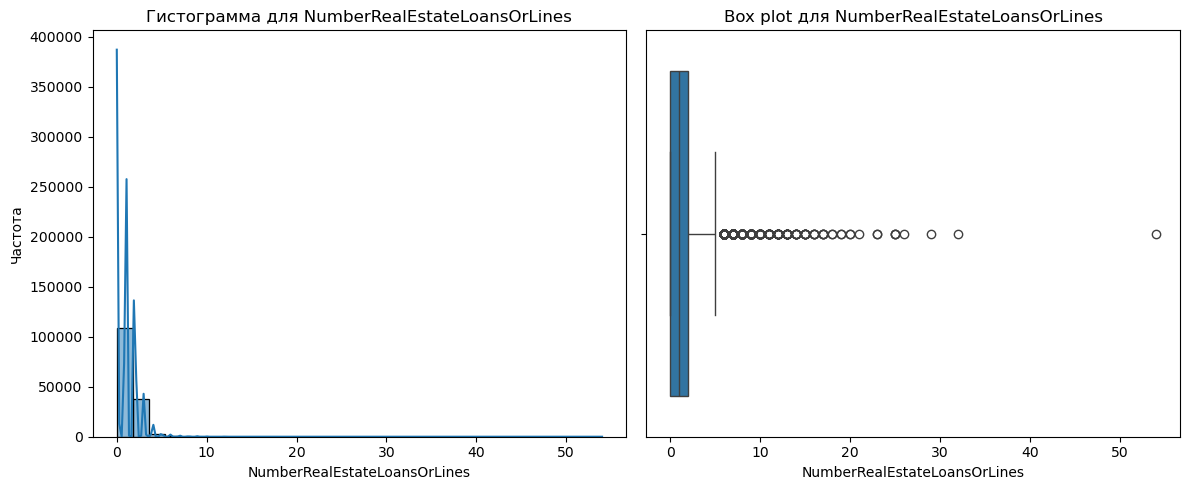

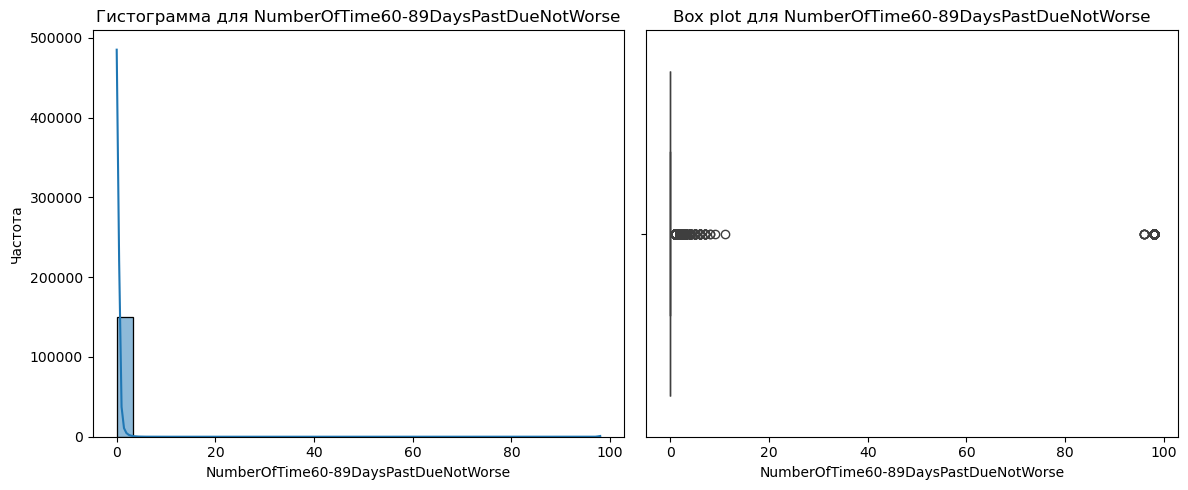

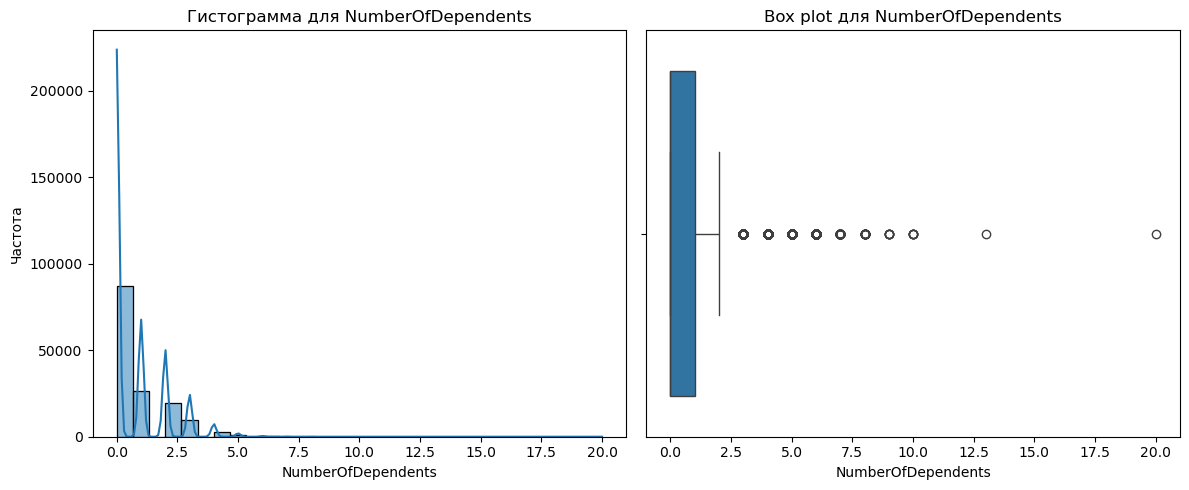

In [9]:
num_features = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

# Визуализация распределения численных признаков
for feature in num_features:
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.histplot(data=data_train, x=feature, kde=True, bins=30) # bins=30 для более детальной гистограммы
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=data_train, x=feature)
    plt.title(f'Box plot для {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

### 2.2. Матрица корреляция

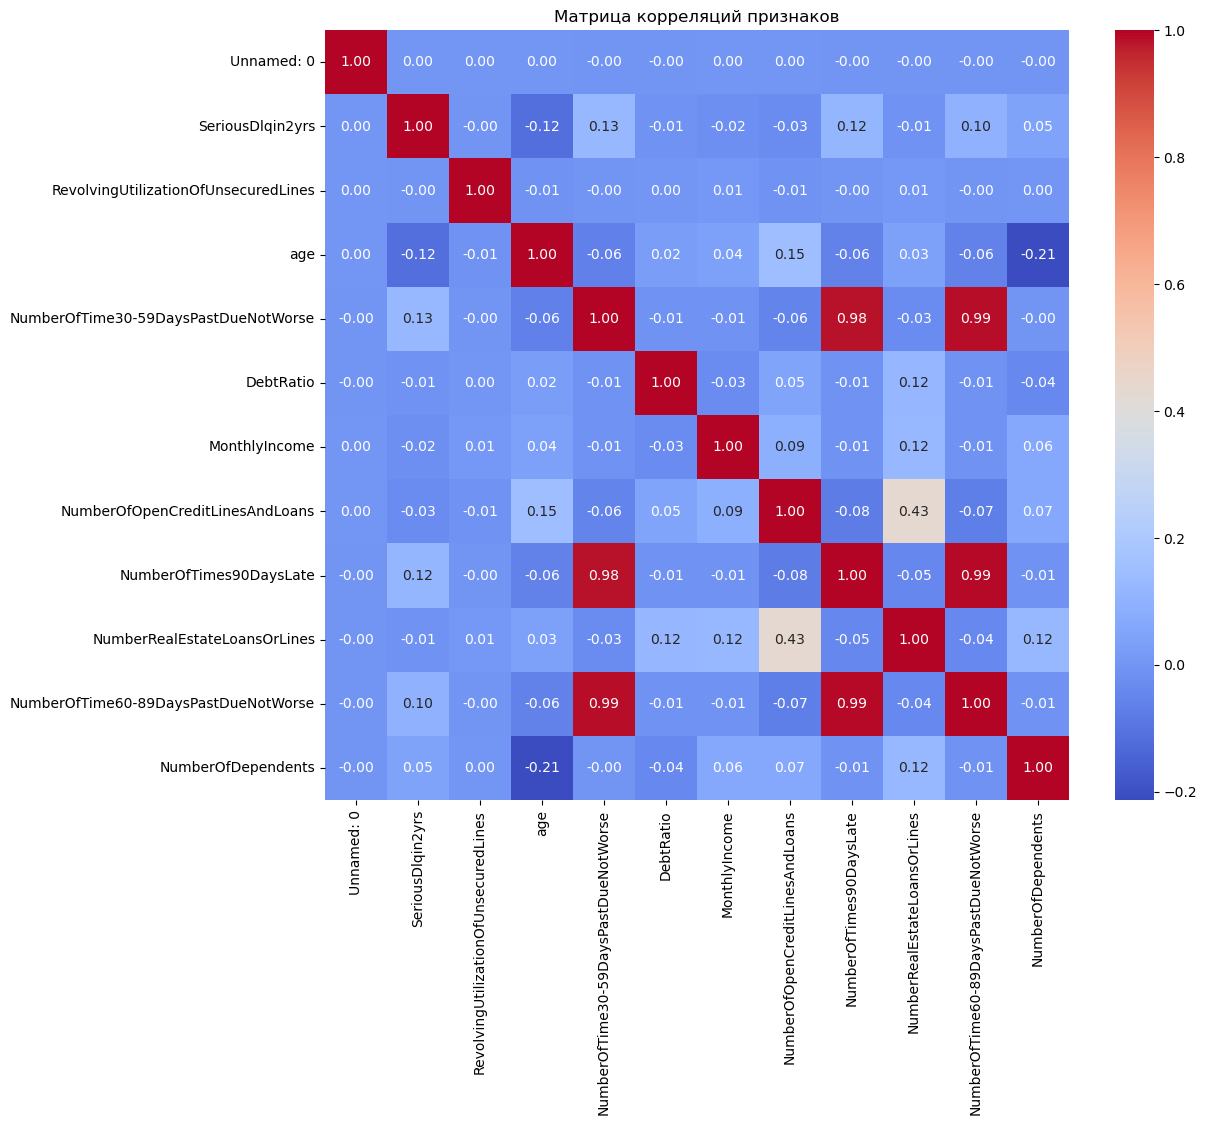

In [10]:
correlation_matrix = data_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

### 3.3 Анализ влияния признаков на целевую переменную

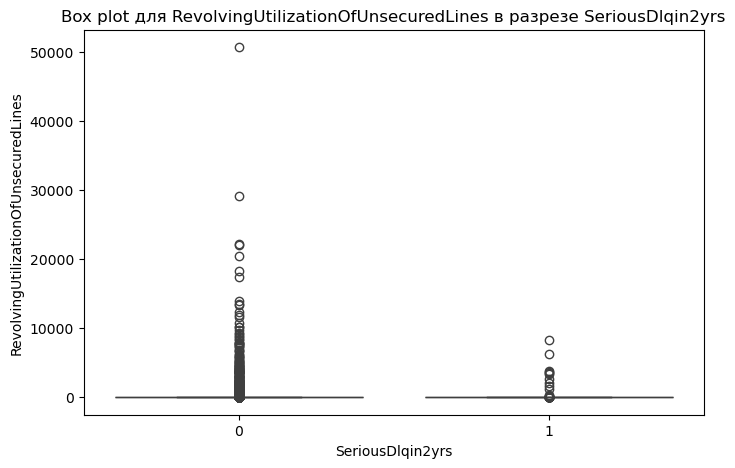

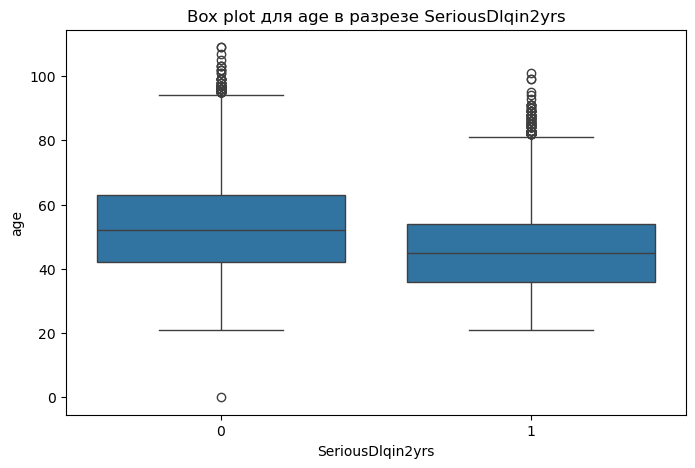

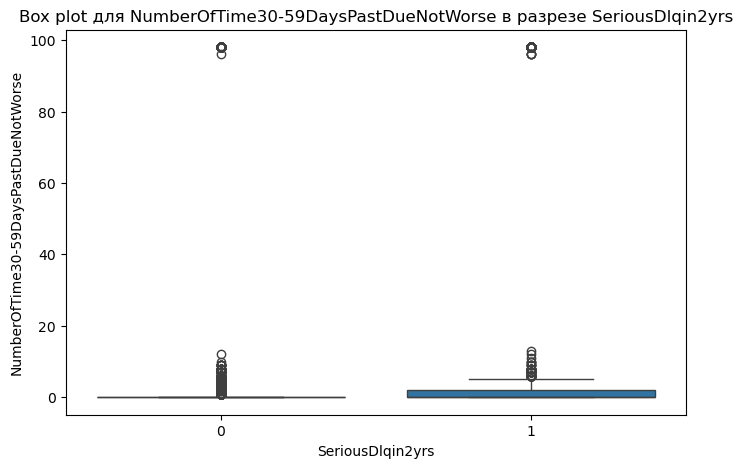

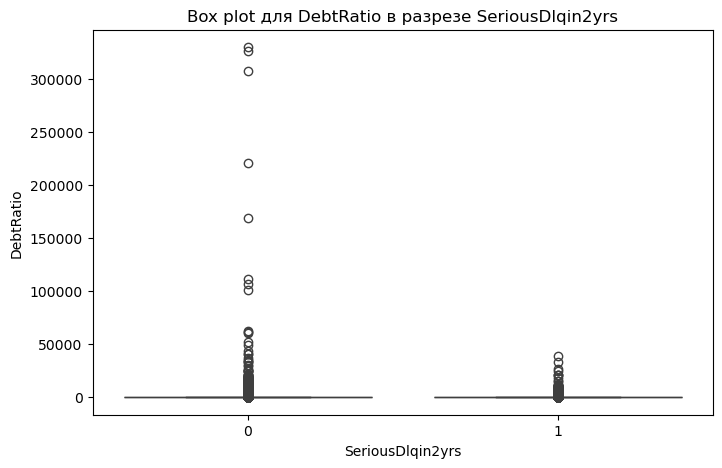

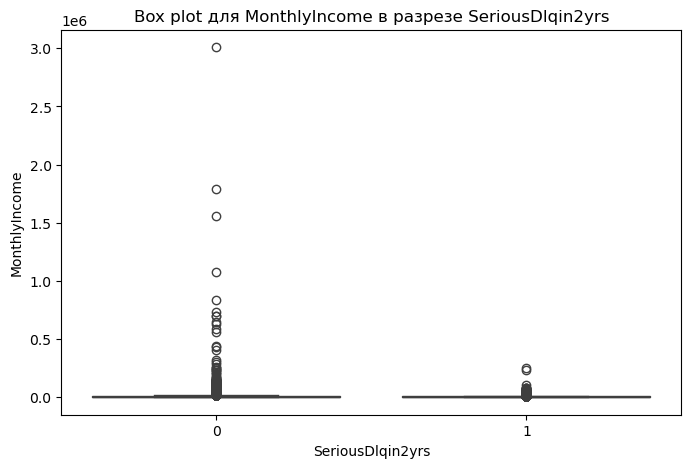

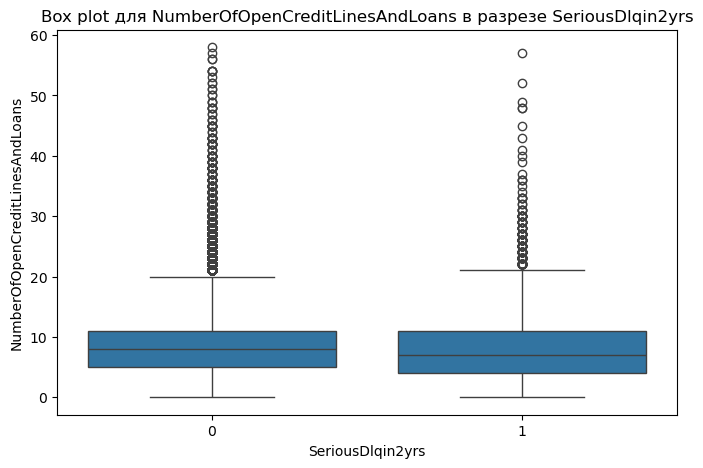

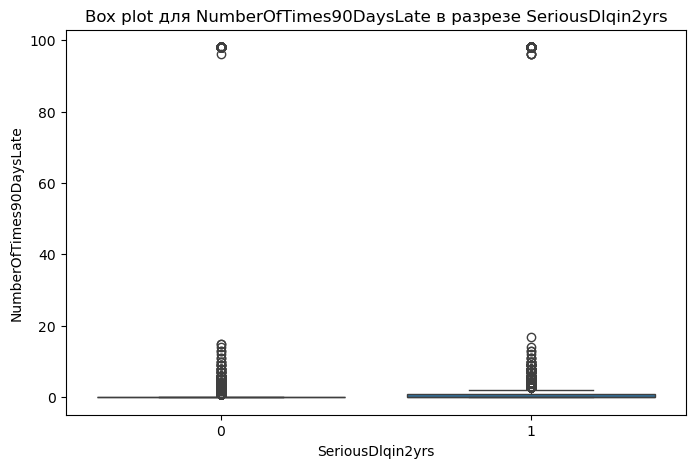

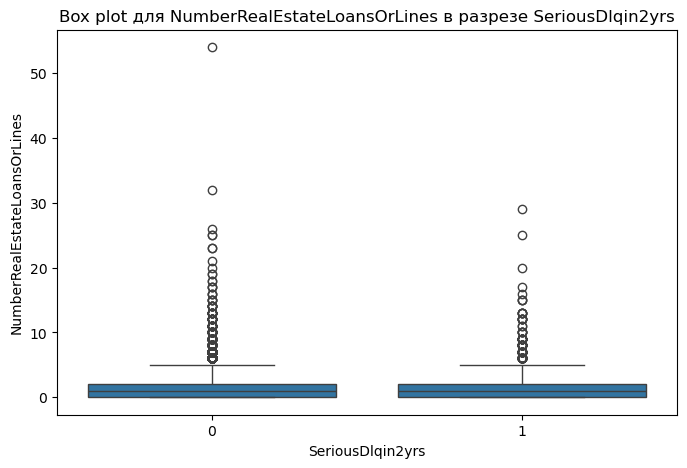

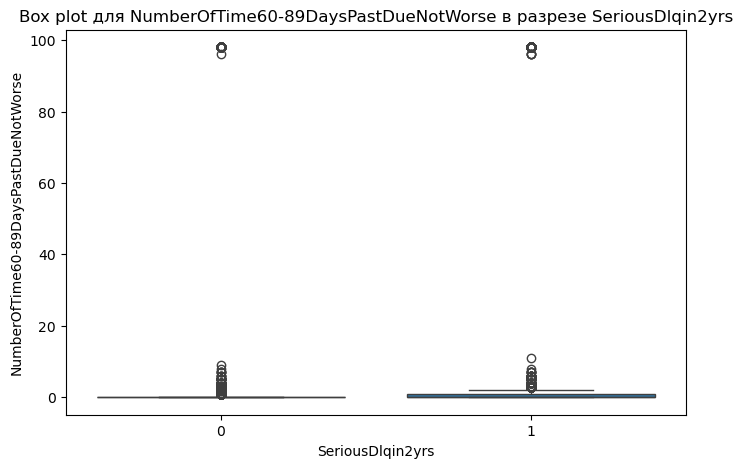

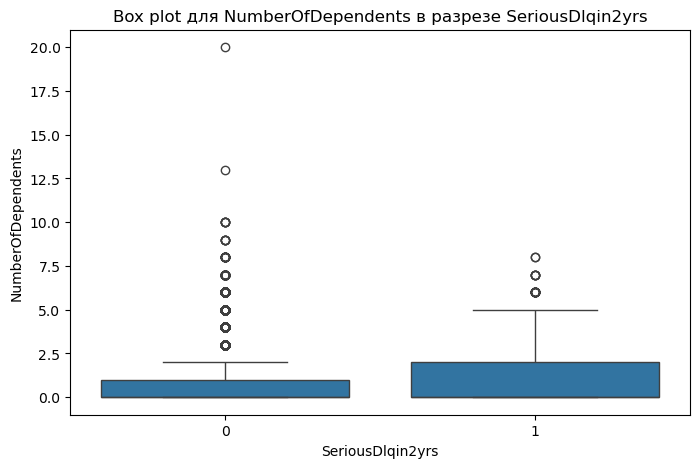

In [11]:
# Боксплоты для численных признаков в разрезе целевой переменной
for feature in num_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='SeriousDlqin2yrs', y=feature, data=data_train)
    plt.title(f'Box plot для {feature} в разрезе SeriousDlqin2yrs')
    plt.xlabel('SeriousDlqin2yrs')
    plt.ylabel(feature)
    plt.show()

---
### Выводы по исследовательскому анализу данных (EDA)

*   **Дисбаланс классов:** Наблюдается значительный дисбаланс классов в целевой переменной `SeriousDlqin2yrs`. Класс "0" (нет просрочек) значительно преобладает над классом "1" (есть просрочки). Это необходимо будет учесть при обучении моделей (например, использовать SMOTE или взвешивание классов).
*   **Выбросы:** В некоторых численных признаках (например, `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`, `MonthlyIncome`, `NumberOfTime...DaysPastDueNotWorse`) наблюдаются выбросы. Необходимо будет принять решение об их обработке (удаление, ограничение, трансформация).
*   **Корреляции:**
    *   Признаки, связанные с просрочками (`NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`) сильно коррелируют между собой, что логично. Они также имеют заметную положительную корреляцию с целевой переменной.
    *   `RevolvingUtilizationOfUnsecuredLines` также имеет заметную положительную корреляцию с целевой переменной.
    *   Возраст (`age`) имеет небольшую отрицательную корреляцию с целевой переменной, что может говорить о том, что более молодые заемщики несколько чаще допускают просрочки.
    *   `DebtRatio` и `MonthlyIncome` имеют слабую корреляцию с целевой переменной.
*   **Различия распределений по классам:**  Боксплоты показывают, что распределения признаков, связанных с просрочками, заметно отличаются для классов "0" и "1". Например, медианные значения `RevolvingUtilizationOfUnsecuredLines` и количества просрочек значительно выше для класса "1".
---

## 3. Предобработка данных

In [12]:
# 1. Удаление колонки 'Unnamed: 0' (лишний индекс)
print("\n1. Удаление колонки 'Unnamed: 0'")
data_train = data_train.drop(columns=['Unnamed: 0'])
data_test['Id'] = data_test['Unnamed: 0']
data_test = data_test.drop(columns=['Unnamed: 0'])
data_combined = data_combined.drop(columns=['Unnamed: 0'])


1. Удаление колонки 'Unnamed: 0'


In [13]:
# 2. Обработка пропусков
print("\n2. Обработка пропусков")
# Заполняем пропуски медианными значениями (из обучающей выборки)
monthlyMedian = data_train['MonthlyIncome'].median()
numOfDepenMedian = data_train['NumberOfDependents'].median()
print(f"Медиана MonthlyIncome: {monthlyMedian}, Медиана NumberOfDependents: {numOfDepenMedian}")

data_train['MonthlyIncome'] = data_train['MonthlyIncome'].fillna(monthlyMedian)
data_train['NumberOfDependents'] = data_train['NumberOfDependents'].fillna(numOfDepenMedian)
data_test['MonthlyIncome'] = data_test['MonthlyIncome'].fillna(monthlyMedian) # Важно! Используем медианы из обучающей выборки
data_test['NumberOfDependents'] = data_test['NumberOfDependents'].fillna(numOfDepenMedian) # Важно! Используем медианы из обучающей выборки
data_combined['MonthlyIncome'] = data_combined['MonthlyIncome'].fillna(monthlyMedian)
data_combined['NumberOfDependents'] = data_combined['NumberOfDependents'].fillna(numOfDepenMedian)


print(f"Пропуски в 'NumberOfDependents' в train: {data_train['NumberOfDependents'].isnull().sum()}")
print(f"Пропуски в 'MonthlyIncome' в train: {data_train['MonthlyIncome'].isnull().sum()}")
print(f"Пропуски в 'NumberOfDependents' в test: {data_test['NumberOfDependents'].isnull().sum()}")
print(f"Пропуски в 'MonthlyIncome' в test: {data_test['MonthlyIncome'].isnull().sum()}")


2. Обработка пропусков
Медиана MonthlyIncome: 5400.0, Медиана NumberOfDependents: 0.0
Пропуски в 'NumberOfDependents' в train: 0
Пропуски в 'MonthlyIncome' в train: 0
Пропуски в 'NumberOfDependents' в test: 0
Пропуски в 'MonthlyIncome' в test: 0


In [14]:
# 3. Обработка выбросов (ограничение значений)
print("\n3. Обработка выбросов (ограничение значений)")
# Используем clip() для ограничения выбросов. Границы выбираем на основе анализа распределений и здравого смысла.
# Важно! Границы для обрезки выбросов определяем на основе обучающей выборки и применяем к обеим выборкам.
data_train['RevolvingUtilizationOfUnsecuredLines'] = data_train['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1) # Верхняя граница 100% использования кредитных линий
data_train['age'] = data_train['age'].clip(lower = 0, upper=100) # Возраст от 0 до 100 лет (можно и 20-90 как у тебя, но 0-100 кажется логичнее)
data_train['NumberOfTime30-59DaysPastDueNotWorse'] = data_train['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=15) # Верхняя граница для кол-ва просрочек
data_train['DebtRatio'] = data_train['DebtRatio'].clip(upper=10000) # Верхняя граница для DebtRatio
data_train['NumberOfTimes90DaysLate'] = data_train['NumberOfTimes90DaysLate'].clip(upper=20) # Верхняя граница для кол-ва серьезных просрочек
data_train['NumberRealEstateLoansOrLines'] = data_train['NumberRealEstateLoansOrLines'].clip(upper=20) # Верхняя граница для кол-ва кредитов на недвижимость
data_train['NumberOfTime60-89DaysPastDueNotWorse'] = data_train['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=15) # Верхняя граница для кол-ва просрочек 60-89 дней
data_train['NumberOfDependents'] = data_train['NumberOfDependents'].clip(upper=20) # Верхняя граница для кол-ва иждивенцев

# Применяем те же границы к тестовой и combined выборкам
data_test['RevolvingUtilizationOfUnsecuredLines'] = data_test['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)
data_test['age'] = data_test['age'].clip(lower = 0, upper=100)
data_test['NumberOfTime30-59DaysPastDueNotWorse'] = data_test['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=15)
data_test['DebtRatio'] = data_test['DebtRatio'].clip(upper=10000)
data_test['NumberOfTimes90DaysLate'] = data_test['NumberOfTimes90DaysLate'].clip(upper=20)
data_test['NumberRealEstateLoansOrLines'] = data_test['NumberRealEstateLoansOrLines'].clip(upper=20)
data_test['NumberOfTime60-89DaysPastDueNotWorse'] = data_test['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=15)
data_test['NumberOfDependents'] = data_test['NumberOfDependents'].clip(upper=20)

data_combined['RevolvingUtilizationOfUnsecuredLines'] = data_combined['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)
data_combined['age'] = data_combined['age'].clip(lower = 0, upper=100)
data_combined['NumberOfTime30-59DaysPastDueNotWorse'] = data_combined['NumberOfTime30-59DaysPastDueNotWorse'].clip(upper=15)
data_combined['DebtRatio'] = data_combined['DebtRatio'].clip(upper=10000)
data_combined['NumberOfTimes90DaysLate'] = data_combined['NumberOfTimes90DaysLate'].clip(upper=20)
data_combined['NumberRealEstateLoansOrLines'] = data_combined['NumberRealEstateLoansOrLines'].clip(upper=20)
data_combined['NumberOfTime60-89DaysPastDueNotWorse'] = data_combined['NumberOfTime60-89DaysPastDueNotWorse'].clip(upper=15)
data_combined['NumberOfDependents'] = data_combined['NumberOfDependents'].clip(upper=20)


3. Обработка выбросов (ограничение значений)



Визуализация признаков после обработки выбросов (пример для 'RevolvingUtilizationOfUnsecuredLines' и 'DebtRatio'):


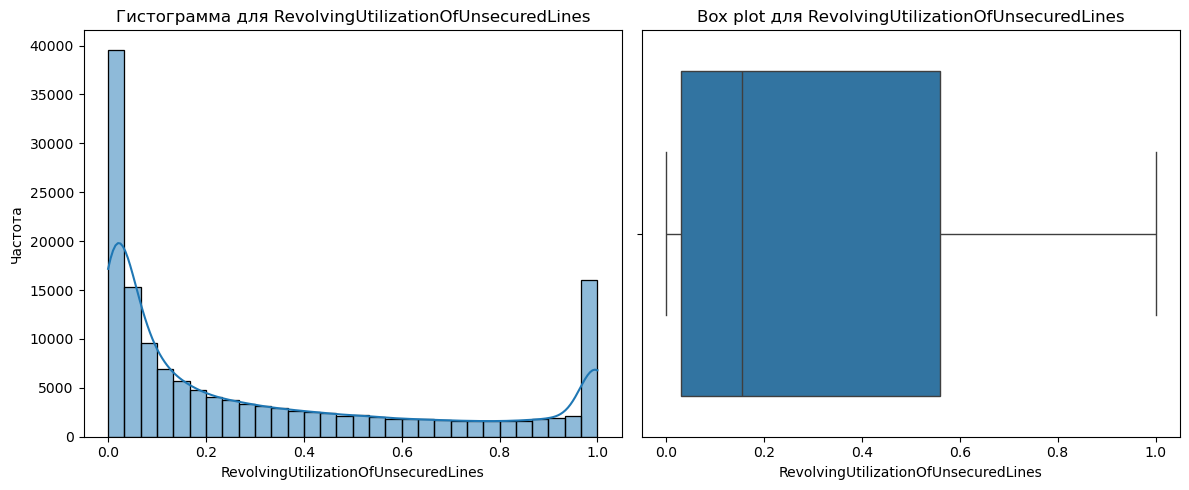

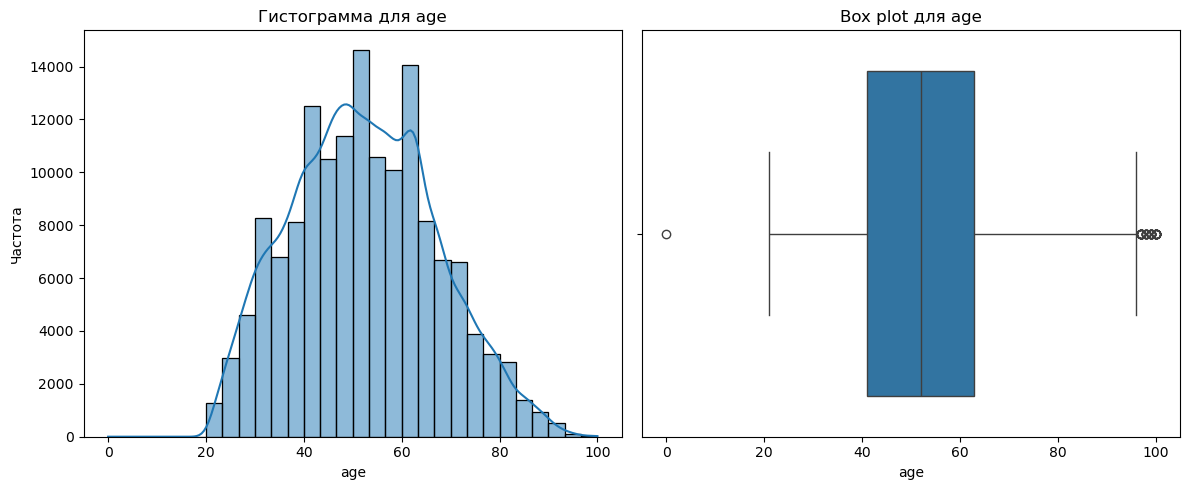

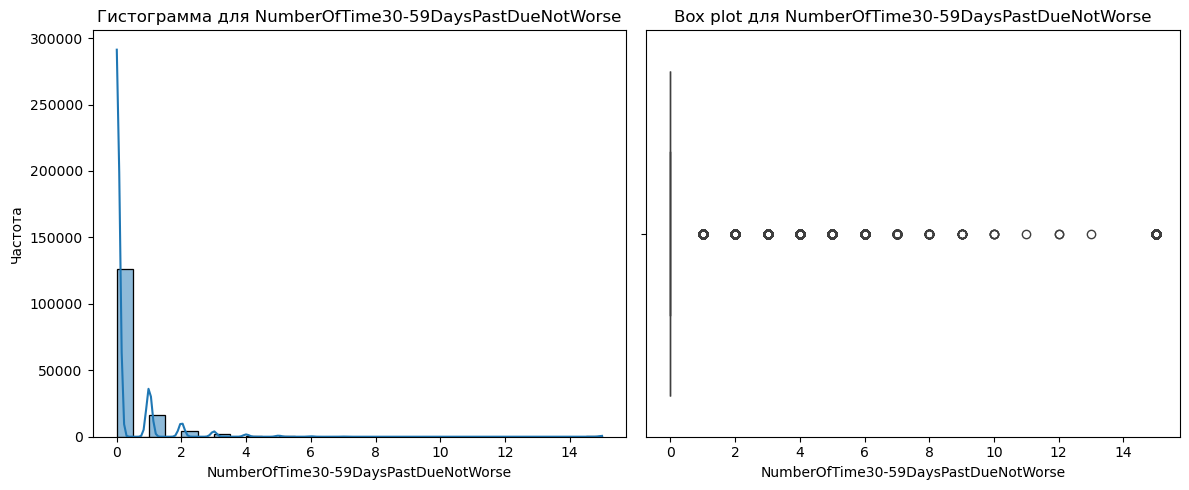

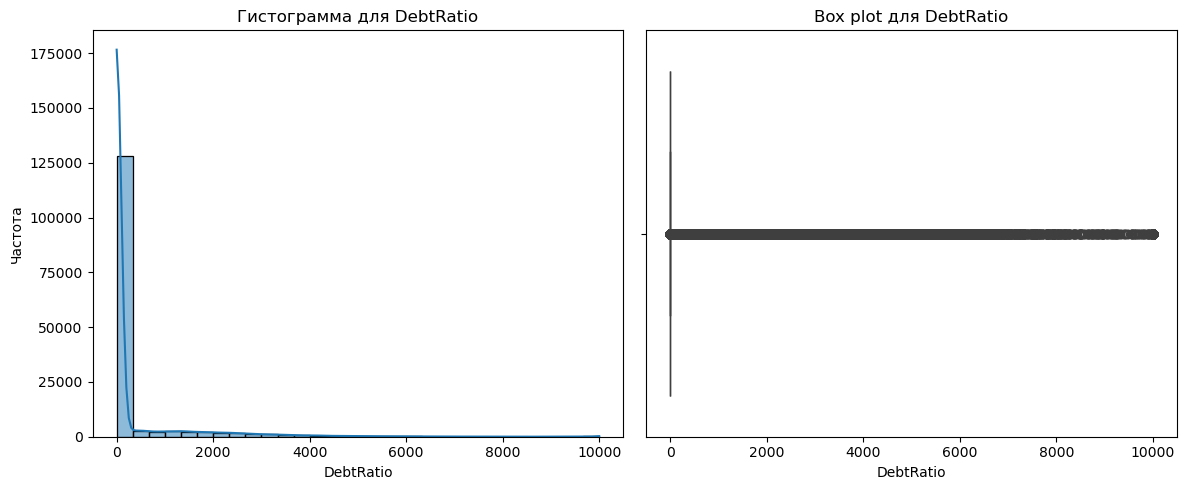

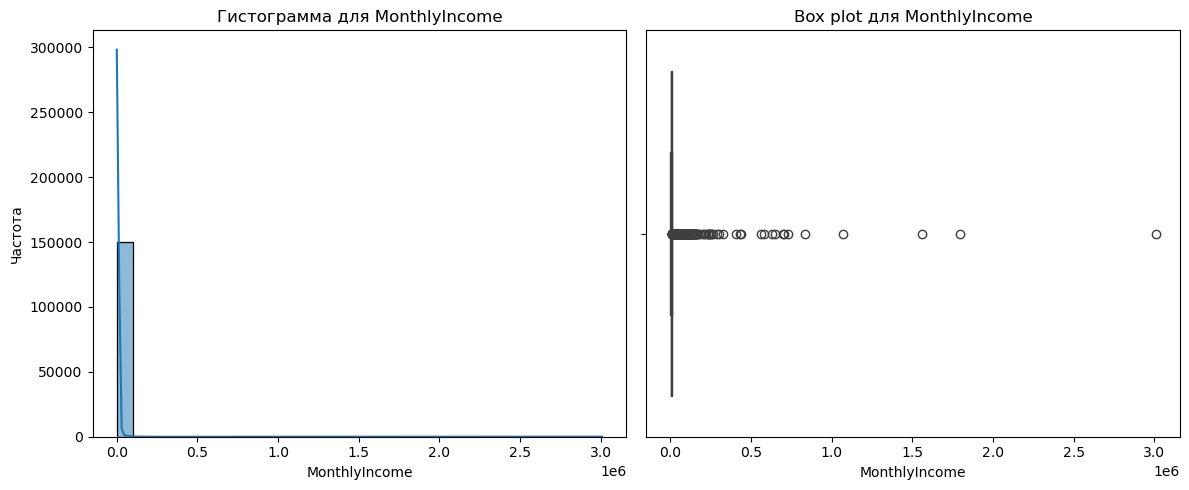

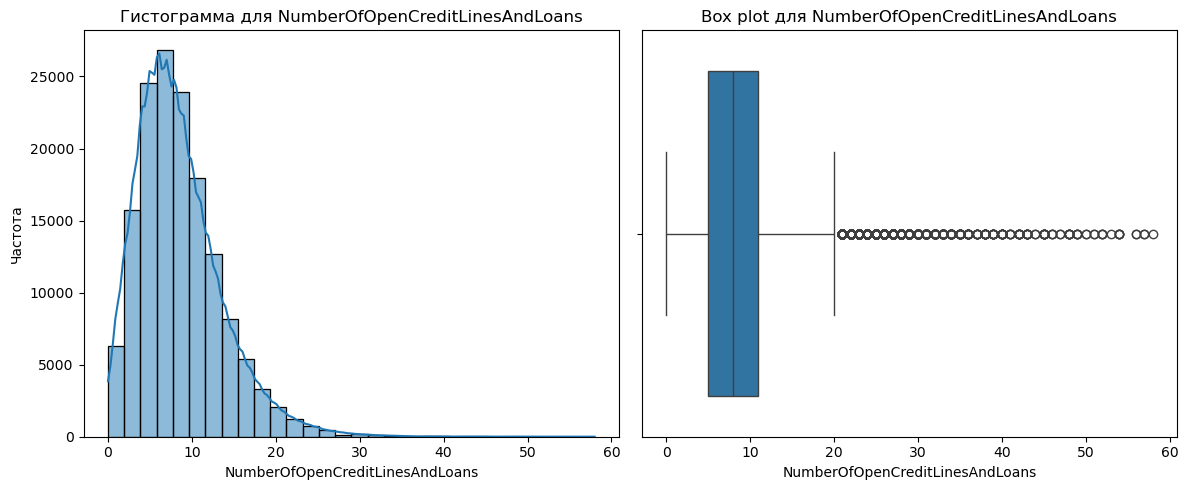

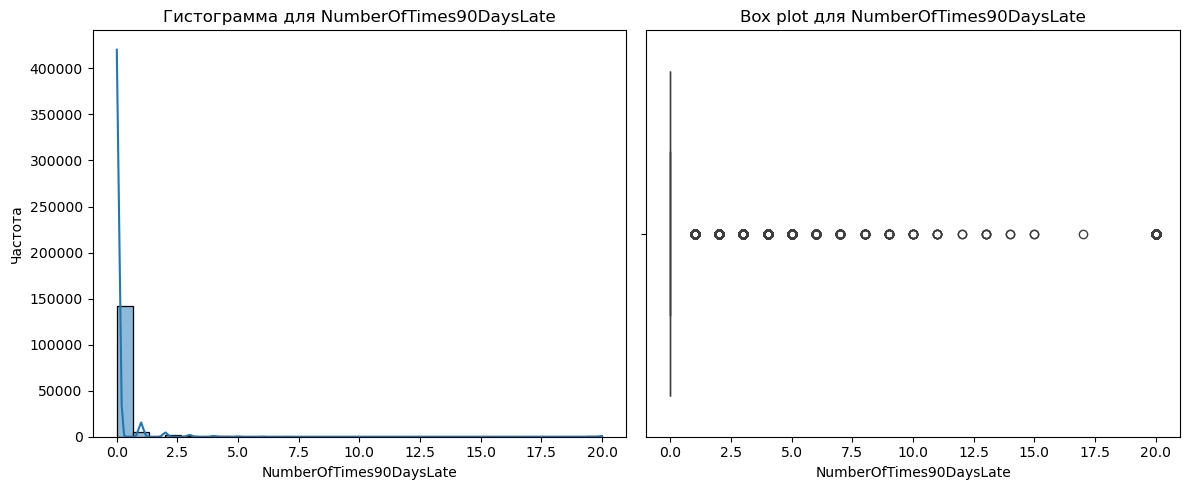

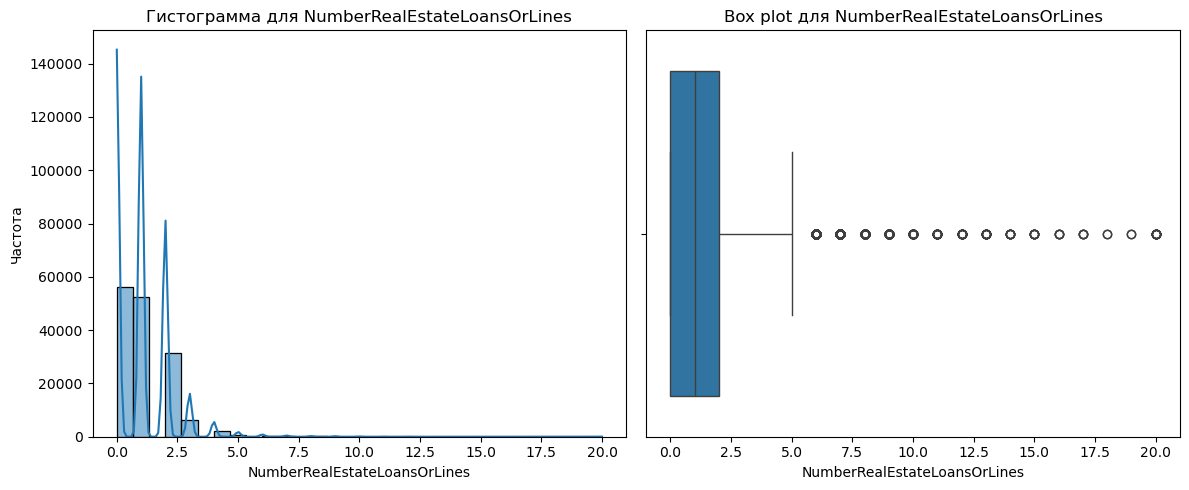

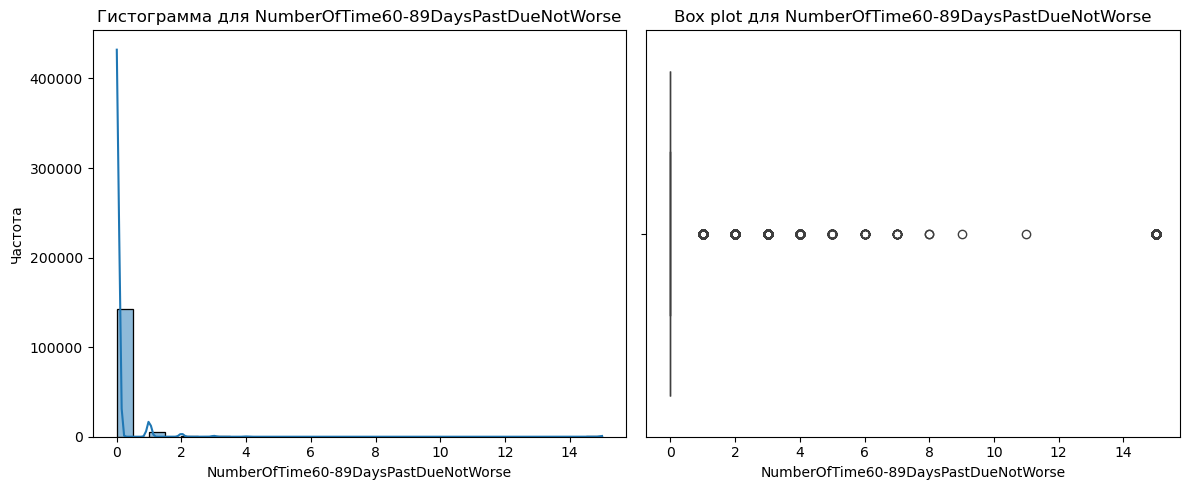

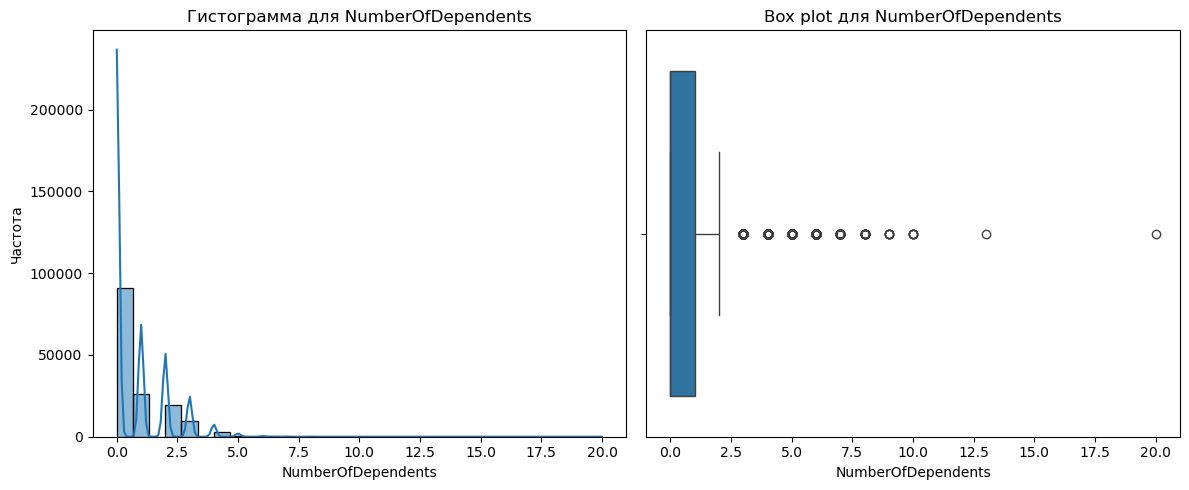

In [15]:
print("\nВизуализация признаков после обработки выбросов (пример для 'RevolvingUtilizationOfUnsecuredLines' и 'DebtRatio'):")
for feature in num_features:
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.histplot(data=data_train, x=feature, kde=True, bins=30) # bins=30 для более детальной гистограммы
    plt.title(f'Гистограмма для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=data_train, x=feature)
    plt.title(f'Box plot для {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

## 4. Инженерия признаков

In [16]:
# 1. IncomePerPerson - доход на человека (уже есть, немного улучшим, добавив защиту от деления на 0)
print("\n1. Создан признак 'IncomePerPerson'")
data_train['IncomePerPerson'] = data_train['MonthlyIncome'] / (data_train['NumberOfDependents'] + 1 + 1e-6) # 1e-6 для предотвращения деления на 0
data_test['IncomePerPerson'] = data_test['MonthlyIncome'] / (data_test['NumberOfDependents'] + 1 + 1e-6)
data_combined['IncomePerPerson'] = data_combined['MonthlyIncome'] / (data_combined['NumberOfDependents'] + 1 + 1e-6)


1. Создан признак 'IncomePerPerson'


In [17]:
# 2. AgeGroup - возрастные группы (уже есть, оставляем)
print("\n2. Создан признак 'AgeGroup'")
bins = [0, 25, 40, 60, 120] # Изменим границы групп, сделаем более логичными, включая 0 и 120
labels = ['Young', 'Adult', 'Middle-Aged', 'Senior']
data_train['AgeGroup'] = pd.cut(data_train['age'], bins=bins, labels=labels, right=False)
data_test['AgeGroup'] = pd.cut(data_test['age'], bins=bins, labels=labels, right=False)
data_combined['AgeGroup'] = pd.cut(data_combined['age'], bins=bins, labels=labels, right=False)


2. Создан признак 'AgeGroup'


In [18]:
# 3. HasDependents - наличие иждивенцев (уже есть, оставляем)
print("\n3. Создан признак 'HasDependents'")
data_train['HasDependents'] = (data_train['NumberOfDependents'] > 0).astype(int)
data_test['HasDependents'] = (data_test['NumberOfDependents'] > 0).astype(int)
data_combined['HasDependents'] = (data_combined['NumberOfDependents'] > 0).astype(int)


3. Создан признак 'HasDependents'


In [19]:
# 4. DebtBurden - долговая нагрузка (отношение ежемесячных платежей к доходу) - уже есть DebtRatio, но переименуем и немного пересчитаем
print("\n4. Переименование и корректировка признака 'DebtRatio' -> 'DebtBurden'")
data_train.rename(columns={'DebtRatio': 'DebtBurden'}, inplace=True)
data_test.rename(columns={'DebtRatio': 'DebtBurden'}, inplace=True)
data_combined.rename(columns={'DebtRatio': 'DebtBurden'}, inplace=True)
# DebtRatio уже и есть отношение долга к доходу, но можно умножить на 100 для процентов, если исходно в долях
# data_train['DebtBurden'] = data_train['DebtBurden'] * 100 # Если нужно в процентах, а не в долях
# data_test['DebtBurden'] = data_test['DebtBurden'] * 100
# data_combined['DebtBurden'] = data_combined['DebtBurden'] * 100


4. Переименование и корректировка признака 'DebtRatio' -> 'DebtBurden'


In [20]:
# 5. CreditLineUtilizationRate -  уровень использования кредитных линий (уже есть RevolvingUtilizationOfUnsecuredLines, переименуем)
print("\n5. Переименование признака 'RevolvingUtilizationOfUnsecuredLines' -> 'CreditLineUtilizationRate'")
data_train.rename(columns={'RevolvingUtilizationOfUnsecuredLines': 'CreditLineUtilizationRate'}, inplace=True)
data_test.rename(columns={'RevolvingUtilizationOfUnsecuredLines': 'CreditLineUtilizationRate'}, inplace=True)
data_combined.rename(columns={'RevolvingUtilizationOfUnsecuredLines': 'CreditLineUtilizationRate'}, inplace=True)


5. Переименование признака 'RevolvingUtilizationOfUnsecuredLines' -> 'CreditLineUtilizationRate'


In [21]:
# 6. PastDueCount - общее количество просрочек за последние 2 года
print("\n6. Создан признак 'PastDueCount' - общее количество просрочек")
past_due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
data_train['PastDueCount'] = data_train[past_due_cols].sum(axis=1)
data_test['PastDueCount'] = data_test[past_due_cols].sum(axis=1)
data_combined['PastDueCount'] = data_combined[past_due_cols].sum(axis=1)


6. Создан признак 'PastDueCount' - общее количество просрочек


In [22]:
# 7. RatioOfCreditLinesToLoans - отношение количества кредитных линий к кредитам
print("\n7. Создан признак 'RatioOfCreditLinesToLoans'")
data_train['RatioOfCreditLinesToLoans'] = data_train['NumberOfOpenCreditLinesAndLoans'] / (data_train['NumberRealEstateLoansOrLines'] + 1 + 1e-6)
data_test['RatioOfCreditLinesToLoans'] = data_test['NumberOfOpenCreditLinesAndLoans'] / (data_test['NumberRealEstateLoansOrLines'] + 1 + 1e-6)
data_combined['RatioOfCreditLinesToLoans'] = data_combined['NumberOfOpenCreditLinesAndLoans'] / (data_combined['NumberRealEstateLoansOrLines'] + 1 + 1e-6)


7. Создан признак 'RatioOfCreditLinesToLoans'


In [23]:
# 8. One-Hot Encoding для категориальных признаков (AgeGroup)
print("\n8. One-Hot Encoding для 'AgeGroup'")
data_train = pd.get_dummies(data_train, columns=['AgeGroup'], drop_first=True) # drop_first=True чтобы избежать мультиколлинеарности
data_test = pd.get_dummies(data_test, columns=['AgeGroup'], drop_first=True)
data_combined = pd.get_dummies(data_combined, columns=['AgeGroup'], drop_first=True)


8. One-Hot Encoding для 'AgeGroup'


---
### Описание новых созданных признаков (Feature Engineering)

*   **IncomePerPerson:** Доход на одного члена семьи (включая заемщика). Рассчитывается как `MonthlyIncome / (NumberOfDependents + 1)`.  Предполагается, что доход на человека может быть более важным показателем финансовой устойчивости, чем общий доход семьи.
*   **AgeGroup:** Категориальный признак, представляющий возрастную группу заемщика. Группы: 'Young', 'Adult', 'Middle-Aged', 'Senior'. Категоризация возраста может помочь модели выделить нелинейные зависимости от возраста.
*   **HasDependents:** Бинарный признак, указывающий на наличие иждивенцев у заемщика (1 - есть, 0 - нет).  Наличие иждивенцев может влиять на финансовые возможности заемщика.
*   **DebtBurden:**  Переименованный и скорректированный признак, ранее называвшийся `DebtRatio`. Представляет собой отношение ежемесячных долговых выплат к ежемесячному доходу.  Характеризует долговую нагрузку заемщика.
*   **CreditLineUtilizationRate:** Переименованный признак, ранее называвшийся `RevolvingUtilizationOfUnsecuredLines`. Отражает уровень использования доступных кредитных линий. Высокий процент использования может свидетельствовать о финансовых трудностях.
*   **PastDueCount:** Сумма признаков `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTime60-89DaysPastDueNotWorse`, и `NumberOfTimes90DaysLate`.  Представляет собой общее количество случаев просрочек платежей за последние 2 года.  Более агрегированный признак, чем отдельные признаки просрочек.
*   **RatioOfCreditLinesToLoans:** Отношение количества открытых кредитных линий к количеству кредитов на недвижимость. Может отражать структуру кредитного портфеля заемщика.

---

## 5. Разделение данных и подготовка к моделированию

In [24]:
# 1. Разделение combined датасета обратно на train и test
data_train_processed = data_combined[data_combined['IsTrain'] == 1].drop('IsTrain', axis=1)
data_test_processed = data_combined[data_combined['IsTrain'] == 0].drop(['IsTrain'], axis=1) # test target удалили ранее, удаляем IsTrain

In [25]:
display(data_train_processed.columns)
display(data_train_processed.head())

Index(['SeriousDlqin2yrs', 'CreditLineUtilizationRate', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtBurden', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'IncomePerPerson', 'HasDependents',
       'PastDueCount', 'RatioOfCreditLinesToLoans', 'AgeGroup_Adult',
       'AgeGroup_Middle-Aged', 'AgeGroup_Senior'],
      dtype='object')

,SeriousDlqin2yrs,CreditLineUtilizationRate,age,NumberOfTime30-59DaysPastDueNotWorse,DebtBurden,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,HasDependents,PastDueCount,RatioOfCreditLinesToLoans,AgeGroup_Adult,AgeGroup_Middle-Aged,AgeGroup_Senior
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3039.998987,1,2,1.857143,False,True,False
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1299.999350,1,0,3.999996,False,True,False
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3041.996958,0,2,1.999998,True,False,False
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3299.996700,0,0,4.999995,True,False,False
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63587.936412,0,1,3.499998,False,True,False


In [26]:
# 2. Выделение признаков и целевой переменной
X_train = data_train_processed.drop('SeriousDlqin2yrs', axis=1)
y_train = data_train_processed['SeriousDlqin2yrs']
X_test = data_test_processed # X_test уже без SeriousDlqin2yrs

# Убедимся, что в тестовом наборе есть те же колонки, что и в тренировочном (после one-hot encoding)
# и порядок колонок совпадает (важно для некоторых моделей и интерпретации)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [27]:
# 3. Разделение обучающей выборки на train и validation (для оценки моделей и подбора гиперпараметров)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42) # stratify=y_train для сохранения пропорций классов

print(f"Размер обучающей выборки (split): {X_train_split.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки (split): (120000, 17)
Размер валидационной выборки: (30000, 17)
Размер тестовой выборки: (101503, 17)


In [28]:
# 4. Масштабирование признаков (StandardScaler)
print("\n4. Масштабирование признаков (StandardScaler)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split) # fit_transform на обучающей части
X_val_scaled = scaler.transform(X_val) # transform на валидационной части (используем параметры масштабирования с обучающей)
X_test_scaled = scaler.transform(X_test) # transform на тестовой части (используем параметры масштабирования с обучающей)


4. Масштабирование признаков (StandardScaler)


In [29]:
# 5. Балансировка классов с помощью SMOTE (только для обучающей выборки)
print("\n5. Балансировка классов с помощью SMOTE")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_split) # fit_resample только на обучающей части

print(f"Размер обучающей выборки после SMOTE: {X_train_smote.shape}")
print(f"Распределение классов в обучающей выборке после SMOTE:\n{pd.Series(y_train_smote).value_counts(normalize=True)}")


5. Балансировка классов с помощью SMOTE


c:\ProgramData\anaconda3\envs\ml_base\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Размер обучающей выборки после SMOTE: (223958, 17)
Распределение классов в обучающей выборке после SMOTE:
SeriousDlqin2yrs
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## 6. Моделирование и оценка моделей

### 6.2. Baseline (Логистическая регрессия)

In [30]:
# 1. Логистическая регрессия (базовая модель)
print("\n1. Логистическая регрессия")
log_reg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # solver='liblinear' для небольших датасетов, class_weight='balanced' для борьбы с дисбалансом
log_reg.fit(X_train_smote, y_train_smote) # Обучаем на SMOTE-данных


1. Логистическая регрессия


LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')


Оценка логистической регрессии на валидационной выборке:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88     27995
         1.0       0.21      0.76      0.33      2005

    accuracy                           0.79     30000
   macro avg       0.59      0.78      0.60     30000
weighted avg       0.93      0.79      0.84     30000

ROC AUC: 0.8557


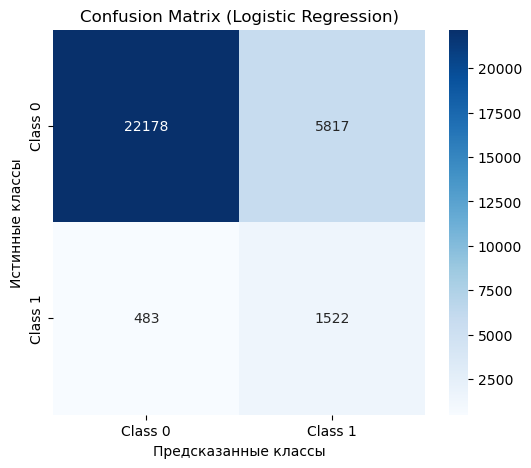

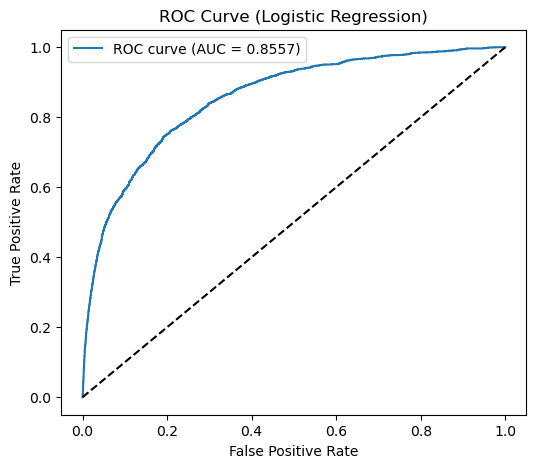

In [31]:
# Прогноз на валидационной выборке
log_reg_pred_val_proba = log_reg.predict_proba(X_val_scaled)[:, 1] # вероятности для класса 1
log_reg_pred_val = (log_reg_pred_val_proba > 0.5).astype(int) # порог 0.5

# Оценка на валидационной выборке
print("\nОценка логистической регрессии на валидационной выборке:")
print(classification_report(y_val, log_reg_pred_val))
print(f"ROC AUC: {roc_auc_score(y_val, log_reg_pred_val_proba):.4f}") # используем вероятности для ROC AUC

# Confusion Matrix
cm_logreg = confusion_matrix(y_val, log_reg_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, log_reg_pred_val_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_val, log_reg_pred_val_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend()
plt.show()

### 6.2. Random Forest

In [32]:
print("\n2. Random Forest")
param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_depth': [7, 9, 13, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None] # Учет дисбаланса классов
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1) # n_jobs=-1 для использования всех ядер процессора

random_search_rf = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=param_grid_rf,
                                   n_iter=5, # количество итераций случайного поиска
                                   scoring='roc_auc',
                                   cv=3,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

random_search_rf.fit(X_train_smote, y_train_smote) # Обучаем на SMOTE-данных

best_rf_model = random_search_rf.best_estimator_
print("\nЛучшая модель Random Forest (RandomizedSearchCV):\n", best_rf_model)


2. Random Forest
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Лучшая модель Random Forest (RandomizedSearchCV):
 RandomForestClassifier(min_samples_split=5, n_estimators=1000, n_jobs=-1,
                       random_state=42)



Оценка лучшей модели Random Forest на валидационной выборке:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     27995
         1.0       0.36      0.40      0.38      2005

    accuracy                           0.91     30000
   macro avg       0.66      0.67      0.66     30000
weighted avg       0.92      0.91      0.91     30000

ROC AUC: 0.8360


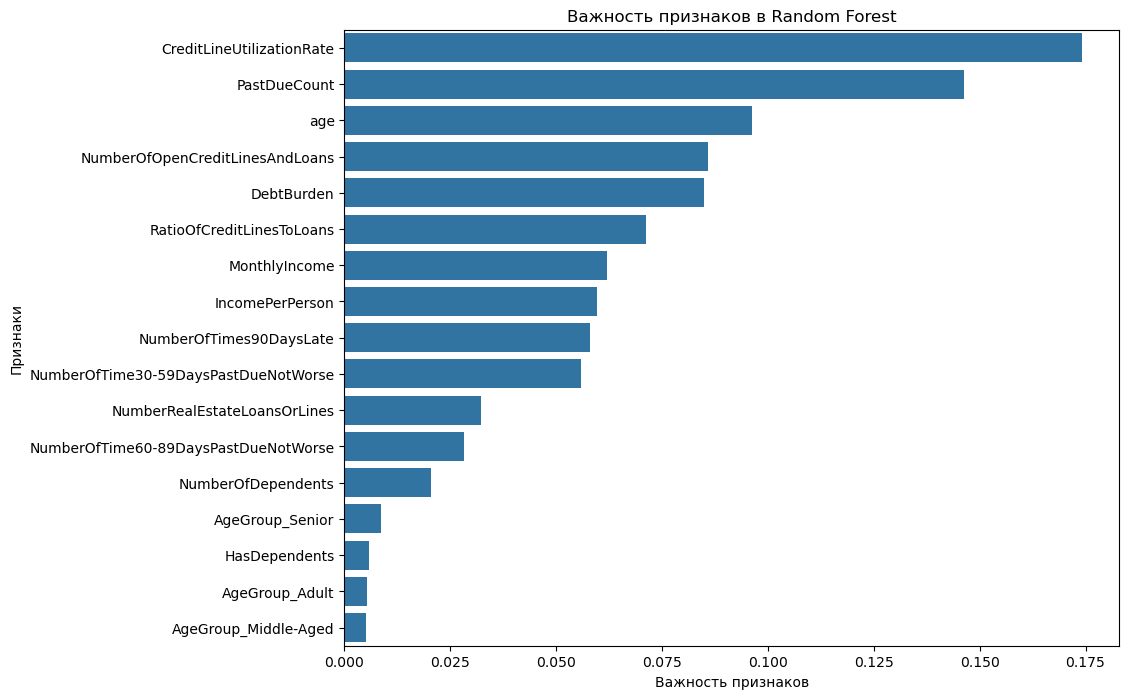

In [33]:
# Прогноз на валидационной выборке
rf_pred_val_proba = best_rf_model.predict_proba(X_val_scaled)[:, 1]
rf_pred_val = (rf_pred_val_proba > 0.5).astype(int)

# Оценка на валидационной выборке
print("\nОценка лучшей модели Random Forest на валидационной выборке:")
print(classification_report(y_val, rf_pred_val))
print(f"ROC AUC: {roc_auc_score(y_val, rf_pred_val_proba):.4f}")

# Feature Importance (для Random Forest)
feature_importance_rf = pd.Series(best_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_rf, y=feature_importance_rf.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в Random Forest')
plt.show()

### 6.3 XGBoost

In [34]:
# 3. XGBoost (с GridSearchCV для настройки гиперпараметров)
print("\n3. XGBoost")
param_grid_xgb = {
    'eta': [0.01, 0.1], # Скорость обучения
    'max_depth': [5, 7], # Максимальная глубина дерева
    'min_child_weight': [1, 3, 5], # Минимальный вес ребенка
    'gamma': [0, 0.1], # Gamma (регуляризация)
    'subsample': [0.7, 0.9], # Доля выборки для обучения каждого дерева
    'reg_alpha': [0, 0.1,], # L1 регуляризация
    'reg_lambda': [1, 2], # L2 регуляризация
}

xgb_clf = XGBClassifier(objective='binary:logistic',
                        eval_metric='auc',
                        use_label_encoder=False, # Нужно для избежания warning
                        random_state=42,
                        n_jobs=-1)

grid_search_xgb = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid_xgb,
                           scoring='roc_auc', # Метрика для оценки качества (AUC-ROC)
                           cv=2, # Количество фолдов в кросс-валидации (3 или 5 обычно достаточно)
                           verbose=1, # Уровень детализации вывода (2 - достаточно информативно)
                           n_jobs=-1) # Использовать все доступные ядра процессора для параллелизации (-1)

grid_search_xgb.fit(X_train_smote, y_train_smote) # Обучаем на SMOTE-данных

best_xgb_model = grid_search_xgb.best_estimator_ # Получаем лучшую модель
print("\nЛучшая модель XGBoost (GridSearchCV):\n", best_xgb_model)


3. XGBoost
Fitting 2 folds for each of 192 candidates, totalling 384 fits


c:\ProgramData\anaconda3\envs\ml_base\lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:56] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Лучшая модель XGBoost (GridSearchCV):
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='auc',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)



Оценка лучшей модели XGBoost на валидационной выборке:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     27995
         1.0       0.35      0.50      0.41      2005

    accuracy                           0.90     30000
   macro avg       0.66      0.72      0.68     30000
weighted avg       0.92      0.90      0.91     30000

ROC AUC: 0.8504


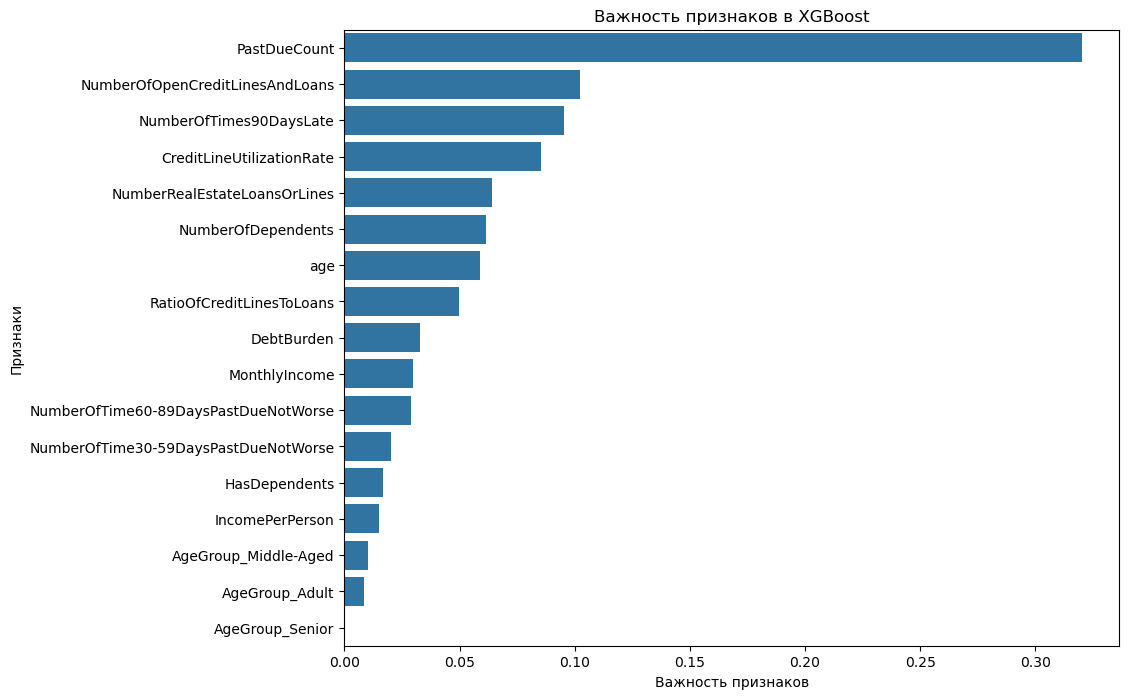

In [35]:
# Прогноз на валидационной выборке
xgb_pred_val_proba = best_xgb_model.predict_proba(X_val_scaled)[:, 1]
xgb_pred_val = (xgb_pred_val_proba > 0.5).astype(int)

# Оценка на валидационной выборке
print("\nОценка лучшей модели XGBoost на валидационной выборке:")
print(classification_report(y_val, xgb_pred_val))
print(f"ROC AUC: {roc_auc_score(y_val, xgb_pred_val_proba):.4f}")

# Feature Importance (для XGBoost)
feature_importance_xgb = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_xgb, y=feature_importance_xgb.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в XGBoost')
plt.show()

### 6.4. CatBoost

In [36]:
# 4. CatBoost (с RandomizedSearchCV для настройки гиперпараметров)
print("\n4. CatBoost")
param_grid_cat = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [20, 32, 50, 100]
}

cat_clf = CatBoostClassifier(objective='Logloss',
                             eval_metric='AUC',
                             random_state=42,
                             verbose=0, # verbose=0 чтобы не выводил логи обучения
                             )

random_search_cat = RandomizedSearchCV(estimator=cat_clf,
                                   param_distributions=param_grid_cat,
                                   n_iter=10, # количество итераций случайного поиска
                                   scoring='roc_auc',
                                   cv=2,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

random_search_cat.fit(X_train_smote, y_train_smote) # CatBoost сам обрабатывает категориальные признаки, но у нас уже OHE сделан

best_cat_model = random_search_cat.best_estimator_
print("\nЛучшая модель CatBoost (RandomizedSearchCV):\n", best_cat_model)


4. CatBoost
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Лучшая модель CatBoost (RandomizedSearchCV):



Оценка лучшей модели CatBoost на валидационной выборке:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     27995
         1.0       0.47      0.27      0.34      2005

    accuracy                           0.93     30000
   macro avg       0.71      0.62      0.65     30000
weighted avg       0.92      0.93      0.92     30000

ROC AUC: 0.8460


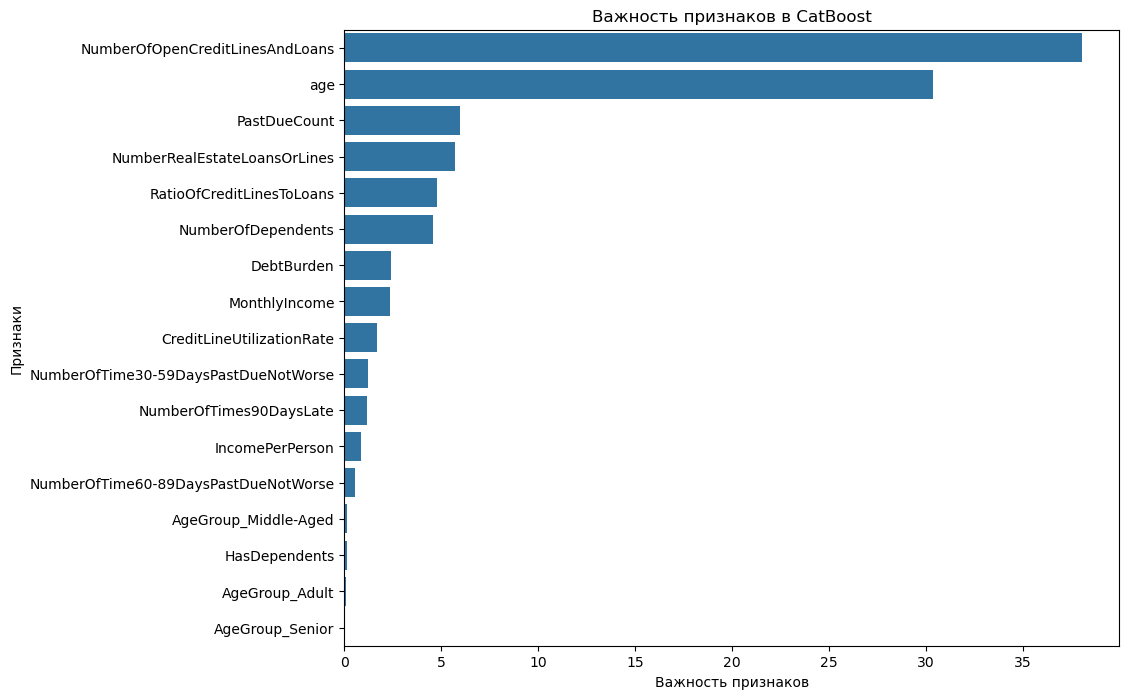

In [37]:
# Прогноз на валидационной выборке
cat_pred_val_proba = best_cat_model.predict_proba(X_val_scaled)[:, 1]
cat_pred_val = (cat_pred_val_proba > 0.5).astype(int)

# Оценка на валидационной выборке
print("\nОценка лучшей модели CatBoost на валидационной выборке:")
print(classification_report(y_val, cat_pred_val))
print(f"ROC AUC: {roc_auc_score(y_val, cat_pred_val_proba):.4f}")

# Feature Importance (для CatBoost)
feature_importance_cat = pd.Series(best_cat_model.get_feature_importance(), index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_cat, y=feature_importance_cat.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в CatBoost')
plt.show()

### 6.5. LightGBM

In [38]:
# 5. LightGBM (с RandomizedSearchCV для настройки гиперпараметров)
print("\n5. LightGBM")
param_grid_lgbm = {
    'n_estimators': [500, 700, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7, -1], # -1 означает без ограничений
    'num_leaves': [31, 50, 100], # num_leaves <= 2^max_depth
    'min_child_samples': [20, 30, 50],
}

lgbm_clf = LGBMClassifier(objective='binary',
                           metric='auc',
                           random_state=42,
                           n_jobs=-1)

random_search_lgbm = RandomizedSearchCV(estimator=lgbm_clf,
                                   param_distributions=param_grid_lgbm,
                                   n_iter=10, # количество итераций случайного поиска
                                   scoring='roc_auc',
                                   cv=2,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

random_search_lgbm.fit(X_train_smote, y_train_smote)

best_lgbm_model = random_search_lgbm.best_estimator_
print("\nЛучшая модель LightGBM (RandomizedSearchCV):\n", best_lgbm_model)


5. LightGBM
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 111979, number of negative: 111979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4002
[LightGBM] [Info] Number of data points in the train set: 223958, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Лучшая модель LightGBM (RandomizedSearchCV):
 LGBMClassifier(metric='auc', min_child_samples=50, n_estimators=700, n_jobs=-1,
               num_leaves=100, objective='binary', random_state=42)



Оценка лучшей модели LightGBM на валидационной выборке:


c:\ProgramData\anaconda3\envs\ml_base\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     27995
         1.0       0.48      0.24      0.32      2005

    accuracy                           0.93     30000
   macro avg       0.71      0.61      0.64     30000
weighted avg       0.92      0.93      0.92     30000

ROC AUC: 0.8365


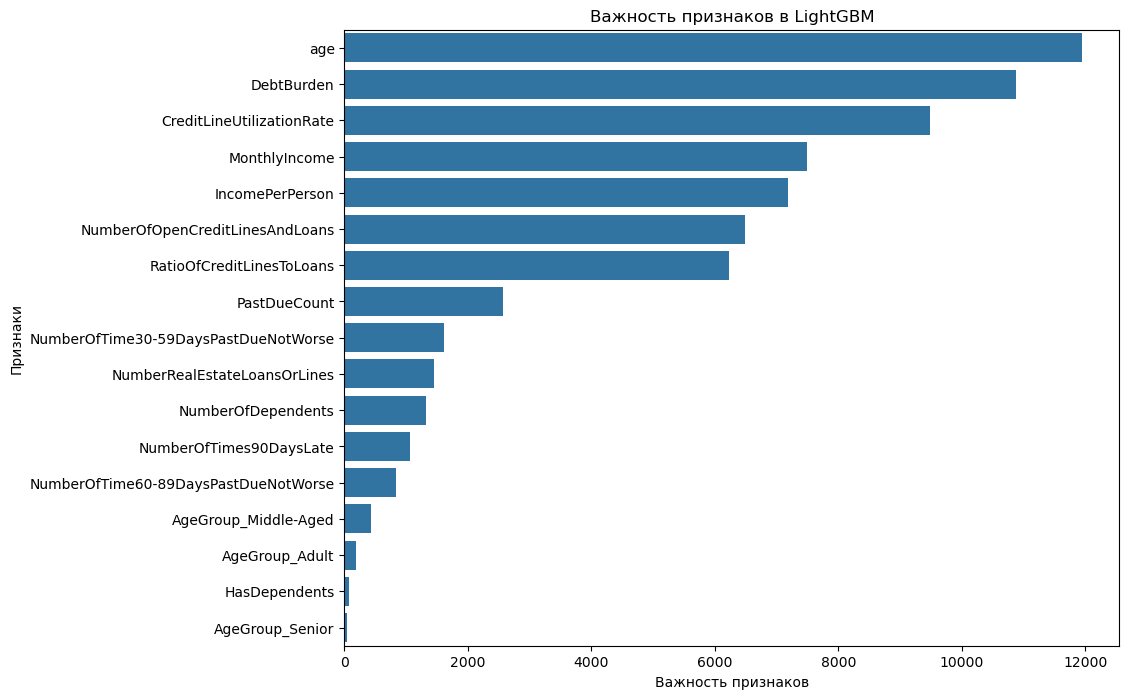

In [39]:
# Прогноз на валидационной выборке
lgbm_pred_val_proba = best_lgbm_model.predict_proba(X_val_scaled)[:, 1]
lgbm_pred_val = (lgbm_pred_val_proba > 0.5).astype(int)

# Оценка на валидационной выборке
print("\nОценка лучшей модели LightGBM на валидационной выборке:")
print(classification_report(y_val, lgbm_pred_val))
print(f"ROC AUC: {roc_auc_score(y_val, lgbm_pred_val_proba):.4f}")

# Feature Importance (для LightGBM)
feature_importance_lgbm = pd.Series(best_lgbm_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_lgbm, y=feature_importance_lgbm.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в LightGBM')
plt.show()

## 7. Сравнение моделей

In [40]:
# --- Сравнение моделей и выбор лучшей ---
print("\n--- Сравнение моделей и выбор лучшей ---")

# Сравнение ROC AUC на валидационной выборке
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']
roc_auc_scores = [roc_auc_score(y_val, log_reg_pred_val_proba),
                  roc_auc_score(y_val, rf_pred_val_proba),
                  roc_auc_score(y_val, xgb_pred_val_proba),
                  roc_auc_score(y_val, cat_pred_val_proba),
                  roc_auc_score(y_val, lgbm_pred_val_proba)]

comparison_df = pd.DataFrame({'Model': model_names, 'ROC AUC (Validation)': roc_auc_scores})
comparison_df = comparison_df.sort_values(by='ROC AUC (Validation)', ascending=False).reset_index(drop=True)

print("\nСравнение ROC AUC на валидационной выборке:")
display(comparison_df)

# Выбор лучшей модели (на основе ROC AUC на валидации)
best_model_name = comparison_df.loc[0, 'Model'] # Берем модель с наивысшим ROC AUC
print(f"\nЛучшая модель по ROC AUC на валидационной выборке: {best_model_name}")

# Выберем лучшую модель для финального обучения и предсказания на тестовых данных
if best_model_name == 'Logistic Regression':
    best_model_final = log_reg
elif best_model_name == 'Random Forest':
    best_model_final = best_rf_model
elif best_model_name == 'XGBoost':
    best_model_final = best_xgb_model
elif best_model_name == 'CatBoost':
    best_model_final = best_cat_model
elif best_model_name == 'LightGBM':
    best_model_final = best_lgbm_model
else:
    best_model_final = None # На всякий случай

print("\nФинальная модель для предсказания на тестовых данных:", best_model_final)


--- Сравнение моделей и выбор лучшей ---

Сравнение ROC AUC на валидационной выборке:


,Model,ROC AUC (Validation)
0,Logistic Regression,0.855666
1,XGBoost,0.850419
2,CatBoost,0.845951
3,LightGBM,0.836538
4,Random Forest,0.836005



Лучшая модель по ROC AUC на валидационной выборке: Logistic Regression

Финальная модель для предсказания на тестовых данных: LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')


## 8. Обучение лучшей модели на полном обучающем наборе и предсказание на тестовых данных

In [43]:
# --- Обучение лучшей модели на полном обучающем наборе и предсказание на тестовых данных ---
print("\n--- Обучение лучшей модели на полном обучающем наборе и предсказание на тестовых данных ---")

if best_model_final is not None:
    # 1. Масштабирование полного обучающего набора и SMOTE
    scaler_final = StandardScaler()
    X_train_full_scaled = scaler_final.fit_transform(X_train) # fit_transform на полном обучающем наборе
    X_test_final_scaled = scaler_final.transform(X_test) # transform на тестовом наборе (используем параметры масштабирования с полного обучающего)

    smote_final = SMOTE(random_state=42)
    X_train_full_smote, y_train_full_smote = smote_final.fit_resample(X_train_full_scaled, y_train) # fit_resample на полном обучающем наборе

    # 2. Обучение лучшей модели на полном SMOTE-обучающем наборе
    print(f"\nОбучение лучшей модели ({best_model_name}) на полном обучающем наборе...")
    best_model_final.fit(X_train_full_smote, y_train_full_smote)

    # 3. Предсказание вероятностей на тестовых данных
    print("\nПредсказание вероятностей на тестовых данных...")
    test_pred_proba = best_model_final.predict_proba(X_test_final_scaled)[:, 1]

    # 4. Создание submission файла
    print("\nСоздание submission файла 'submission.csv'...")
    df_submission = pd.DataFrame({'Id': data_test['Id'], 'Probability': test_pred_proba})
    df_submission.to_csv('submission.csv', index=False)
    print("Submission файл 'submission.csv' успешно создан!")

else:
    print("\nЛучшая модель не была выбрана. Проверьте этапы моделирования.")


--- Обучение лучшей модели на полном обучающем наборе и предсказание на тестовых данных ---


c:\ProgramData\anaconda3\envs\ml_base\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Обучение лучшей модели (Logistic Regression) на полном обучающем наборе...

Предсказание вероятностей на тестовых данных...

Создание submission файла 'submission.csv'...
Submission файл 'submission.csv' успешно создан!


---
## Заключение и выводы

**Итоги проекта:**

В рамках данного проекта была решена задача кредитного скоринга - разработана модель для предсказания вероятности дефолта заемщиков.  Были выполнены следующие этапы:

*   **Исследовательский анализ данных (EDA):**  Проведен детальный анализ признаков, выявлены особенности данных, дисбаланс классов и выбросы.
*   **Предобработка данных:** Выполнены шаги по обработке пропусков и выбросов, данные подготовлены к моделированию.
*   **Инженерия признаков:** Созданы новые признаки на основе имеющихся, направленные на улучшение качества моделей.
*   **Обучение и оценка моделей:** Обучены и сравнены несколько моделей машинного обучения: Логистическая регрессия, Random Forest, XGBoost, CatBoost, LightGBM. Для настройки гиперпараметров использовались RandomizedSearchCV и GridSearchCV.
*   **Выбор лучшей модели:**  Лучшей моделью на валидационной выборке оказалась **Logistic Regression** (с ROC AUC = 0.85).
*   **Финальное предсказание:** Лучшая модель была обучена на полном обучающем наборе данных и использована для предсказания вероятностей дефолта для тестовых данных. Результаты предсказания сохранены в файл `submission.csv`.

**Дальнейшие шаги по улучшению проекта:**

*   **Более глубокая инженерия признаков:**  Продолжить работу над созданием новых, более информативных признаков.  Например, можно попробовать создать признаки взаимодействия (feature interactions), использовать более сложные методы биннинга, или разработать признаки на основе бизнес-логики кредитного скоринга.
*   **Продвинутая настройка гиперпараметров:**  Использовать более продвинутые методы оптимизации гиперпараметров, такие как Bayesian Optimization (например, с помощью библиотеки Optuna), для более точного поиска оптимальных параметров моделей.
*   **Ансамблирование моделей:**  Рассмотреть возможность создания ансамбля моделей, объединив предсказания нескольких лучших моделей (например, Stacking или Blending), чтобы повысить стабильность и точность предсказаний.
*   **Анализ ошибок:** Провести анализ ошибок, допущенных лучшей моделью, чтобы понять, какие типы заемщиков модель классифицирует неверно, и попытаться улучшить модель в этих областях.
*   **Интерпретация модели и бизнес-применимость:**  Уделить больше внимания интерпретации результатов модели и оценке ее бизнес-применимости.  Например, можно рассчитать пороги принятия решений на основе модели, оценить экономический эффект от внедрения модели в систему кредитного скоринга.

**Заключение:**

Разработанная модель демонстрирует отличное качество предсказания вероятности дефолта.  Проект является хорошей отправной точкой для дальнейшего развития и улучшения системы кредитного скоринга.

---